In [6]:


import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
import math
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score, precision_score, recall_score
from keras.preprocessing import text, sequence
from keras.layers import Embedding
from keras import layers, models, optimizers
import xgboost as xgb
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [7]:

df = pd.read_csv("train.csv")
print("train data with shape : ", df.shape)
  


train data with shape :  (1306122, 3)


In [8]:
df.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
df = df.drop(['qid'],axis = 1)

In [10]:
df.shape

(1306122, 2)

In [11]:
df_sincere = df.loc[df['target'] == 0]
df_insincere = df.loc[df['target'] == 1]

In [12]:
df_sincere_sampled = df_sincere.sample(80000,random_state=42)
df_insincere_sampled = df_insincere.sample(80000,random_state=42)

In [13]:
df_sincere_sampled.shape

(80000, 2)

In [14]:
df_main = pd.concat([df_insincere_sampled,df_sincere_sampled])

In [15]:
df_main.shape

(160000, 2)

In [16]:
def clean_misspell(text):
    """
    misspell list (quora vs. glove)
    """
    misspell_to_sub = {
        '(T|t)erroristan': 'terrorist Pakistan',
        'BIMARU': 'Bihar, Madhya Pradesh, Rajasthan, Uttar Pradesh',
        '(H|h)induphobic': 'Hindu phobic',
        '(H|h)induphobia': 'Hindu phobic',
        'Babchenko': 'Arkady Arkadyevich Babchenko faked death',
        'Boshniaks': 'Bosniaks',
        'Dravidanadu': 'Dravida Nadu',
        'mysoginists': 'misogynists',
        'MGTOWS': 'Men Going Their Own Way',
        'mongloid': 'Mongoloid',
        'unsincere': 'insincere',
        'meninism': 'male feminism',
        'jewplicate': 'jewish replicate',
        'unoin': 'Union',
        'daesh': 'Islamic State of Iraq and the Levant',
        'Kalergi': 'Coudenhove-Kalergi',
        ' apist': ' Ape',
        '(B|b)hakts': 'Bhakt',
        'Tambrahms': 'Tamil Brahmin',
        'Pahul': 'Amrit Sanskar',
        'SJW(s|)': 'social justice warrior',
        'incel(s|)': 'involuntary celibates',
        'emiratis': 'Emiratis',
        'weatern': 'western',
        'Pizzagate': 'Pizzagate conspiracy theory',
        'naïve': 'naive',
        'Skripal': 'Sergei Skripal',
        '(R|r)emainers': 'remainer',
        'antibrahmin': 'anti Brahminism',
        'HYPSM': ' Harvard, Yale, Princeton, Stanford, MIT',
        'HYPS': ' Harvard, Yale, Princeton, Stanford',
        'kompromat': 'compromising material',
        '(T|t)harki': 'pervert',
        'mastuburate': 'masturbate',
        'Zoë': 'Zoe',
        'indans': 'Indian',
        'xender': 'gender',
        'Naxali': 'Naxalite',
        'Bathla': 'Namit Bathla',
        'Mewani': 'Indian politician Jignesh Mevani',
        'clichéd': 'cliché',
        'cliché(s|)': 'cliché',
        'Wjy': 'Why',
        'Fadnavis': 'Indian politician Devendra Fadnavis',
        'Awadesh': 'Indian engineer Awdhesh Singh',
        'Awdhesh': 'Indian engineer Awdhesh Singh',
        'Khalistanis': 'Sikh separatist movement',
        'madheshi': 'Madheshi',
        'Quorans': 'Quoran',
        'BNBR': 'Be Nice, Be Respectful',
        'Bolsonaro': 'Jair Bolsonaro',
        'XXXTentacion': 'Tentacion',
        'Padmavat': 'Indian Movie Padmaavat',
        'Žižek': 'Slovenian philosopher Slavoj Žižek',
        'Adityanath': 'Indian monk Yogi Adityanath',
        '(B|b)rexit': 'British Exit',
        'jallikattu': 'Jallikattu',
        'fortnite': 'Fortnite',
        'Swachh': 'Swachh Bharat mission campaign',
        'Qoura': 'Quora',
        'narcissit': 'narcissist',
        # extra in sample
        'Doklam': 'Tibet',
        'Drumpf': 'Donald Trump',
        'Strzok': 'Hillary Clinton scandal',
        'rohingya': 'Rohingya',
        'wumao': 'offensive Chinese',
        'Sanghis': 'Sanghi',
        'Tamilans': 'Tamils',
        'biharis': 'Biharis',
        'Rejuvalex': 'hair growth formula',
        'Feku': 'The Man of India',
        'deplorables': 'deplorable',
        'muhajirs': 'Muslim immigrants',
        'Brexiters': 'British Exit supporters',
        'Brexiteers': 'British Exit supporters',
        'Brexiting': 'British Exit',
        'Gujratis': 'Gujarati',
        'Chutiya': 'Tibet people',
        'thighing': 'masturbate',
        '卐': 'Nazi Germany',
        'rohingyas': 'Muslim ethnic group',
        'Pribumi': 'Native Indonesians',
        'Gurmehar': 'Gurmehar Kaur Indian student activist',
        'Novichok': 'Soviet Union agents',
        'Khazari': 'Khazars',
        'Demonetization': 'demonetization',
        'demonetisation': 'demonetization',
        'cryptocurrencies': 'bitcoin',
        'Hindians': 'offensive Indian',
        'vaxxers': 'vocal nationalists',
        'remoaners': 'remainer',
        'Jewism': 'Judaism',
        'Eroupian': 'European',
        'WMAF': 'White male Asian female',
        'moeslim': 'Muslim',
        'cishet': 'cisgender and heterosexual person',
        'Eurocentrics': 'Eurocentrism',
        'Jewdar': 'Jew dar',
        'Asifas': 'abduction, rape, murder case',
        'marathis': 'Marathi',
        'Trumpanzees': 'Trump chimpanzee',
        'quoras': 'Quora',
        'Crimeans': 'Crimea people',
        'atrracted': 'attract',
        'LGBT': 'lesbian, gay, bisexual, transgender',
        'Boshniaks': 'Bosniaks',
        'Myeshia': 'widow of Green Beret killed in Niger',
        'demcoratic': 'Democratic',
        'raaping': 'rape',
        'Dönmeh': 'Islam',
        'feminazism': 'feminism nazi',
        'Quroa': 'Quora',
        'QUORA': 'Quora',
        'langague': 'language',
        '(H|h)ongkongese': 'HongKong people',
        '(K|k)ashmirians': 'Kashmirian',
        '(C|c)hodu': 'fucker',
        'penish': 'penis',
        'micropenis': 'small penis',
        'Madridiots': 'Madrid idiot',
        'Ambedkarites': 'Dalit Buddhist movement',
        'ReleaseTheMemo': 'cry for the right and Trump supporters',
        'harrase': 'harass',
        '(B|b)arracoon': 'Black slave',
        '(C|c)astrater': 'castration',
        '(R|r)apistan': 'rapist Pakistan',
        '(T|t)urkified': 'Turkification',
        'Dumbassistan': 'dumb ass Pakistan',
        'facetards': 'Facebook retards',
        'rapefugees': 'rapist refugee',
        'superficious': 'superficial',
        # extra from kagglers
        'colour': 'color',
        'centre': 'center',
        'favourite': 'favorite',
        'travelling': 'traveling',
        'counselling': 'counseling',
        'theatre': 'theater',
        'cancelled': 'canceled',
        'labour': 'labor',
        'organisation': 'organization',
        'wwii': 'world war 2',
        'citicise': 'criticize',
        'youtu ': 'youtube ',
        'Qoura': 'Quora',
        'sallary': 'salary',
        'Whta': 'What',
        'narcisist': 'narcissist',
        'narcissit': 'narcissist',
        'howdo': 'how do',
        'whatare': 'what are',
        'howcan': 'how can',
        'howmuch': 'how much',
        'howmany': 'how many',
        'whydo': 'why do',
        'doI': 'do I',
        'theBest': 'the best',
        'howdoes': 'how does',
        'mastrubation': 'masturbation',
        'mastrubate': 'masturbate',
        'mastrubating': 'masturbating',
        'pennis': 'penis',
        'Etherium': 'Ethereum',
        'bigdata': 'big data',
        '2k17': '2017',
        '2k18': '2018',
        'qouta': 'quota',
        'exboyfriend': 'ex boyfriend',
        'airhostess': 'air hostess',
        'whst': 'what',
        'watsapp': 'whatsapp',
        'demonitisation': 'demonetization',
        'demonitization': 'demonetization',
        'demonetisation': 'demonetization'
    }
    misspell_re = re.compile('(%s)' % '|'.join(misspell_to_sub.keys()))

    def _replace(match):
        """
        reference: https://www.kaggle.com/hengzheng/attention-capsule-why-not-both-lb-0-694 # noqa
        """
        return misspell_to_sub.get(match.group(0), match.group(0))
    return misspell_re.sub(_replace, text)


In [17]:
def spacing_misspell(text):
    """
    'deadbody' -> 'dead body'
    """
    misspell_list = [
        'body',
        '(D|d)ead',
        '(N|n)orth',
        '(K|k)orea',
        'matrix',
        '(S|s)hit',
        '(F|f)uck',
        '(F|f)uk',
        '(F|f)ck',
        '(D|d)ick',
        'Trump',
        '\W(A|a)nti',
        '(W|w)hy',
        # 'Jew',
        'bait',
        'care',
        'troll',
        'over',
        'gender',
        'people',
        'kind',
        '(S|s)ick',
        '(S|s)uck',
        '(I|i)diot',
        # 'hole(s|)\W',
        '(B|b)ooty',
        '(C|c)oin(s|)\W',
        '\W(N|n)igger'
    ]
    misspell_re = re.compile('(%s)' % '|'.join(misspell_list))
    return misspell_re.sub(r" \1 ", text)


def clean_latex(text):
    """
    convert r"[math]\vec{x} + \vec{y}" to English
    """
    # edge case
    text = re.sub(r'\[math\]', ' LaTex math ', text)
    text = re.sub(r'\[\/math\]', ' LaTex math ', text)
    text = re.sub(r'\\', ' LaTex ', text)

    pattern_to_sub = {
        r'\\mathrm': ' LaTex math mode ',
        r'\\mathbb': ' LaTex math mode ',
        r'\\boxed': ' LaTex equation ',
        r'\\begin': ' LaTex equation ',
        r'\\end': ' LaTex equation ',
        r'\\left': ' LaTex equation ',
        r'\\right': ' LaTex equation ',
        r'\\(over|under)brace': ' LaTex equation ',
        r'\\text': ' LaTex equation ',
        r'\\vec': ' vector ',
        r'\\var': ' variable ',
        r'\\theta': ' theta ',
        r'\\mu': ' average ',
        r'\\min': ' minimum ',
        r'\\max': ' maximum ',
        r'\\sum': ' + ',
        r'\\times': ' * ',
        r'\\cdot': ' * ',
        r'\\hat': ' ^ ',
        r'\\frac': ' / ',
        r'\\div': ' / ',
        r'\\sin': ' Sine ',
        r'\\cos': ' Cosine ',
        r'\\tan': ' Tangent ',
        r'\\infty': ' infinity ',
        r'\\int': ' integer ',
        r'\\in': ' in ',
    }
    # post process for look up
    pattern_dict = {k.strip('\\'): v for k, v in pattern_to_sub.items()}
    # init re
    patterns = pattern_to_sub.keys()
    pattern_re = re.compile('(%s)' % '|'.join(patterns))

    def _replace(match):
        """
        reference: https://www.kaggle.com/hengzheng/attention-capsule-why-not-both-lb-0-694 # noqa
        """
        return pattern_dict.get(match.group(0).strip('\\'), match.group(0))
    return pattern_re.sub(_replace, text)

In [18]:
def normalize_unicode(text):
    """
    unicode string normalization
    """
    return unicodedata.normalize('NFKD', text)


def remove_newline(text):
    """
    remove \n and  \t
    """
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = re.sub('\b', ' ', text)
    text = re.sub('\r', ' ', text)
    return text


def decontracted(text):
    """
    de-contract the contraction
    """
    # specific
    text = re.sub(r"(W|w)on(\'|\’)t", "will not", text)
    text = re.sub(r"(C|c)an(\'|\’)t", "can not", text)
    text = re.sub(r"(Y|y)(\'|\’)all", "you all", text)
    text = re.sub(r"(Y|y)a(\'|\’)ll", "you all", text)

    # general
    text = re.sub(r"(I|i)(\'|\’)m", "i am", text)
    text = re.sub(r"(A|a)in(\'|\’)t", "is not", text)
    text = re.sub(r"n(\'|\’)t", " not", text)
    text = re.sub(r"(\'|\’)re", " are", text)
    text = re.sub(r"(\'|\’)s", " is", text)
    text = re.sub(r"(\'|\’)d", " would", text)
    text = re.sub(r"(\'|\’)ll", " will", text)
    text = re.sub(r"(\'|\’)t", " not", text)
    text = re.sub(r"(\'|\’)ve", " have", text)
    return text


def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    regular_punct = list(string.punctuation)
    extra_punct = [
        ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&',
        '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
        '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
        '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
        '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
        '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
        '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
        'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
        '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
        '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']
    all_punct = ''.join(sorted(list(set(regular_punct + extra_punct))))
    re_tok = re.compile(f'([{all_punct}])')
    return re_tok.sub(r' \1 ', text)


def spacing_digit(text):
    """
    add space before and after digits
    """
    re_tok = re.compile('([0-9])')
    return re_tok.sub(r' \1 ', text)


def spacing_number(text):
    """
    add space before and after numbers
    """
    re_tok = re.compile('([0-9]{1,})')
    return re_tok.sub(r' \1 ', text)


def remove_number(text):
    """
    numbers are not toxic
    """
    return re.sub('\d+', ' ', text)


def remove_space(text):
    """
    remove extra spaces and ending space if any
    """
    text = re.sub('\s+', ' ', text)
    text = re.sub('\s+$', '', text)
    return text


In [19]:
def preprocess(text, remove_num=True):
    """
    preprocess text into clean text for tokenization
    NOTE:
        1. glove supports uppper case words
        2. glove supports digit
        3. glove supports punctuation
        5. glove supports domains e.g. www.apple.com
        6. glove supports misspelled words e.g. FUCKKK
    """
    # # 1. normalize
    # text = normalize_unicode(text)
    # # 2. remove new line
    # text = remove_newline(text)
    # 3. de-contract
    text = decontracted(text)
    # 4. clean misspell
    text = clean_misspell(text)
    # 5. space misspell
    text = spacing_misspell(text)
    # 6. clean_latex
    text = clean_latex(text)
    # 7. space
    text = spacing_punctuation(text)
    # 8. handle number
    if remove_num:
        text = remove_number(text)
    else:
        text = spacing_digit(text)
    # 9. remove space
    text = remove_space(text)
    return text

In [20]:
df_main['question_text'] = df_main['question_text'].apply(lambda s : preprocess(s))

In [21]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

question_words = list()
lines = df_main['question_text'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    question_words.append(words)

In [23]:
import gensim
EMBEDDING_DIM = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=question_words, size=EMBEDDING_DIM, window=1, workers=4, min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 58951


In [24]:
import os

embeddings_index = {}
f = open('embedding_word2vec.txt',  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [25]:
X_train, X_test,y_train, y_test = train_test_split(df_main['question_text'],df_main.target, test_size = 0.2)

In [26]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(question_words)
sequences = tokenizer_obj.texts_to_sequences(question_words)
# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

Found 58951 unique tokens.


In [27]:
review_pad = pad_sequences(sequences, maxlen=100)
sentiment =  df_main['target'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

Shape of review tensor: (160000, 100)
Shape of sentiment tensor: (160000,)


In [28]:
# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(0.2 * review_pad.shape[0])

In [29]:
X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

In [30]:
print('Shape of X_train_pad tensor:', X_train_pad)
print('Shape of y_train tensor:', y_train)

print('Shape of X_test_pad tensor:', X_test_pad)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: [[   0    0    0 ...  375 2605 1059]
 [   0    0    0 ...   10 6957  630]
 [   0    0    0 ... 1015  685  125]
 ...
 [   0    0    0 ...   74 1737  432]
 [   0    0    0 ... 3806  776  853]
 [   0    0    0 ...   20   80 3728]]
Shape of y_train tensor: [1 0 1 ... 0 0 1]
Shape of X_test_pad tensor: [[    0     0     0 ...  4887  1251     1]
 [    0     0     0 ...  1532   236  6163]
 [    0     0     0 ...   783  1854   267]
 ...
 [    0     0     0 ...   354  8139 13302]
 [    0     0     0 ...   517   424   406]
 [    0     0     0 ...   239     2  1295]]
Shape of y_test tensor: (32000,)


In [37]:
clf = XGBClassifier(n_estimators = 500, max_depth=15, n_jobs=3)

In [38]:
clf.fit(X_train_pad, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=3, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
# make predictions for test data
y_pred = clf.predict(X_test_pad)
predictions = [round(value) for value in y_pred]
print(predictions)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 

In [40]:
cf_matrix = confusion_matrix(predictions, y_test)

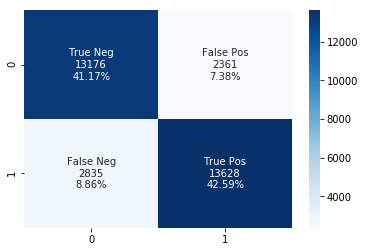

In [41]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [42]:
print(accuracy_score(predictions, y_test))

0.837625


In [43]:
print(f1_score(predictions, y_test))

0.8398866017502774
